## Import all the needed libraries:

In [2]:
from __future__ import print_function, division
import os

import torch
from torch.autograd import Variable
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from skimage import io, transform
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import xml.etree.ElementTree as ET
from copy import deepcopy
import random

from moviepy.editor import VideoFileClip,ImageSequenceClip
from IPython.display import HTML
import matplotlib.image as mpimg

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import cv2

import pickle
from pylab import *
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
cdict = {'red': ((0.0, 1.0, 1.0),
                 (0.125, 1.0, 1.0),
                 (0.25, 1.0, 1.0),
                 (0.5625, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.5625, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),
         'blue': ((0.0, 0.0, 0.0),
                  (0.5, 0.0, 0.0),
                  (1.0, 0.0, 0.0))}
my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

%matplotlib inline
# %matplotlib notebook

In [14]:
import numpy as np
a = [float('nan') , 1 , float('nan')]
b = [0 if np.isnan(x) else x for x in a]

In [18]:
a =[]
b =np.mean(a)
b

/home/shuo/anaconda2/envs/pytorch/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shuo/anaconda2/envs/pytorch/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

## Import, filter and smooth raw data:

In [ ]:
which_data = 'Data_2015_DES_I235E'
(Traffic_2015,Weather_2015,data_2015) = pickle.load( open(which_data+".p", "rb" ) )
year =  data_2015['y'][0][:4]
print('load {} data'.format(year))

which_data = 'Data_2016_DES_I235E'
(Traffic_2016,Weather_2016,data_2016) = pickle.load( open(which_data+".p", "rb" ) )
year =  data_2016['y'][0][:4]
print('load {} data'.format(year))



In [ ]:
def replace_nan_with_local_mean(M_3d):
    index = np.asarray(np.where(np.isnan(M_3d)))
    for i in range(index.shape[1]):
        span = 0
        historical = M_3d[index[0,i],index[1,i],index[2,i]-span:index[2,i]+1+span]
        historical_mean = np.nanmean(historical)
        stage_1_flag = True
        count = 0 
        while (not historical_mean>0) & stage_1_flag:
            count+=1
            if count > 1000:
                print('1st ',count)
            if index[0,i]-span<0:
                historical = M_3d[0:index[0,i]+1+span+span,index[1,i],index[2,i]]
            elif index[0,i]+1+span>M_3d.shape[0]:
                historical = M_3d[-1-span-span:,index[1,i],index[2,i]]
            else:
                historical = M_3d[index[0,i]-span:index[0,i]+1+span,index[1,i],index[2,i]]
            historical_mean = np.nanmean(historical)
            span+=1
            if 2*span>M_3d.shape[0]:
                stage_1_flag = False
        span = 0
        count = 0 
        while not historical_mean>0:
            count+=1
            if count > 1000:
                print('2nd ',count)
            if index[2,i]-span<0:
                historical = M_3d[:,index[1,i],0:index[2,i]+1+span+span]
            elif index[2,i]+1+span>M_3d.shape[2]:
                historical = M_3d[:,index[1,i],-1-span-span:]
            else:
                historical = M_3d[:,index[1,i],index[2,i]-span:index[2,i]+1+span]
            historical_mean = np.nanmean(historical)
            span+=1
#         print(historical_mean)

        span = 0
        count = 0 
        local = M_3d[index[0,i],index[1,i],index[2,i]-span:index[2,i]+1+span]
        local_mean = np.nanmean(local)
        stage_1_flag = True
        while (not local_mean>0) & stage_1_flag:
            count+=1
            if count > 1000:
                print('3rd ',count)
            if index[2,i]-span<0:
                local = M_3d[index[0,i],index[1,i],0:index[2,i]+1+span+span]
            elif index[2,i]+1+span>M_3d.shape[2]:
                local = M_3d[index[0,i],index[1,i],-1-span-span:]
            else:
                local = M_3d[index[0,i],index[1,i],index[2,i]-span:index[2,i]+1+span]
            local_mean = np.nanmean(local)
            span+=1
            if 2*span>M_3d.shape[2]:
                stage_1_flag = False
        
        span = 0
        count = 0 
        while not local_mean>0:
            count+=1
            if count > 1000:
                print('4th ',count)
            if index[1,i]-span<0:
                local = M_3d[index[0,i],0:index[1,i]+1+span+span,:]
            elif index[1,i]+1+span>M_3d.shape[1]:
                local = M_3d[index[0,i],-1-span-span:,:]
            else:
                local = M_3d[index[0,i],index[1,i]-span:index[1,i]+1+span,:]
            local_mean = np.nanmean(local)
            span+=1
        
#         print(local_mean)
        M_3d[index[0,i],index[1,i],index[2,i]] = 0.7*local_mean + 0.3*historical_mean
    return M_3d

In [ ]:
def volume_smoothing(Volume,top_threshold = 400):
    Volume[Volume>top_threshold] = nan
    Volume = replace_nan_with_local_mean(Volume)
    return Volume

def speed_smoothing(Speed,top_threshold = 120):
    Speed[Speed>top_threshold] = nan
    Speed = replace_nan_with_local_mean(Speed)
    Speed[Speed == 0] = nan
    Speed = replace_nan_with_local_mean(Speed)
    return Speed

print('Filter traffic data .....')
# Traffic_2015[:,:,:,0] = speed_smoothing(Traffic_2015[:,:,:,0])
# Traffic_2015[:,:,:,1] = volume_smoothing(Traffic_2015[:,:,:,1])

# Traffic_2016[:,:,:,0] = speed_smoothing(Traffic_2016[:,:,:,0])
# Traffic_2016[:,:,:,1] = volume_smoothing(Traffic_2016[:,:,:,1])
print('Done')

def moving_avg_batch(data,window_length=5):
    data_new = np.zeros(data.shape)
    for i in range(window_length):
        data_shift = np.copy(data)
        data_shift[:,:,i:]=data[:,:,:data.shape[2]-i]
        data_new += data_shift
    return data_new/window_length

def data_smoothing_moving_avg(data,window_length=5):
    data_new = np.copy(data)
    if len(data.shape)==4:
        for i in range(data.shape[-1]):
            data_new[:,:,:,i] = moving_avg_batch(data[:,:,:,i],window_length=window_length)
    if len(data.shape)==3:
        data_new = moving_avg_batch(data,window_length=window_length)
    return data_new

print('Smooth traffic data .....')
# Traffic_2015 = data_smoothing_moving_avg(Traffic_2015)
# Traffic_2016 = data_smoothing_moving_avg(Traffic_2016)
print('Done')


In [ ]:
# pickle.dump( (Traffic_2015,Weather_2015,data_2015), open( 'Data_2015_DES_I235E'+'_filter_smooth.p', "wb" ) )
# pickle.dump( (Traffic_2016,Weather_2016,data_2016), open( 'Data_2016_DES_I235E'+'_filter_smooth.p', "wb" ) )

## Import saved smoothed data (start from here)

In [3]:
which_data = 'Data_2015_DES_I235E'
(Traffic_2015,Weather_2015,data_2015) = pickle.load( open(which_data+"_filter_smooth.p", "rb" ) )
year =  data_2015['y'][0][:4]
print('{} data loaded'.format(year))

which_data = 'Data_2016_DES_I235E'
(Traffic_2016,Weather_2016,data_2016) = pickle.load( open(which_data+"_filter_smooth.p", "rb" ) )
year =  data_2016['y'][0][:4]
print('{} data loaded'.format(year))

data = pd.concat([data_2015,data_2016],ignore_index=True)
Traffic = np.concatenate([Traffic_2015, Traffic_2016],axis = 0)
Weather_5min = np.concatenate([Weather_2015, Weather_2016],axis = 0)
Weather = np.zeros([Weather_5min.shape[0],Weather_5min.shape[1],Weather_5min.shape[2]*5,Weather_5min.shape[3]])
for i in range(Weather.shape[2]):
    Weather[:,:,i,:] = Weather_5min[:,:,int(i/5),:]
Weather = np.delete(Weather,1,axis=3)

2015 data loaded
2016 data loaded


## Pytorch Data Base
* ### Multi-output: each sample includes {'traffic':(15,1439,3),'weather':(15,1439,10),'history':(6,15,1439,3),'label':(15,1439)}
* ### Single-output: each sample includes {'traffic':(15,1439,3),'weather':(15,1439,10),'history':(6,15,1439,3),'label':(1439,)}
* ### note: in 'history', non-existing days in database are represented in nans

In [6]:
class LSTM_SpeedPrediction_database_output_single_sensor(Dataset):
    def __init__(self, Traffic, Weather, data, transform=None, look_back = 6, target_sensor = 13):

        self.Traffic = Traffic
        self.Weather = Weather
        self.data = data
        self.transform = transform
        self.look_back = look_back
        self.target_sensor = target_sensor
#         print(self.__len__())
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        assert idx < self.__len__(),'idx out of dataset index boundary'
        
        Traffic_today = self.Traffic[idx,:,:-1,:]
        Weather_today = self.Weather[idx,:,:-1,:]
        Traffic_history = 0
        Traffic_output = self.Traffic[idx,self.target_sensor,1:,0]
        
        dayofweek = self.data.loc[idx]['dayofweek']
        data_sub = self.data[:idx]
        sameday_in_history = data_sub.index[data_sub['dlen(sameday_in_history)ayofweek'] == dayofweek].tolist()
        
        Traffic_history = np.full((self.look_back,)+self.Traffic.shape[1:], np.nan)
#         print(len(sameday_in_history))
        sameday_in_near_history = sameday_in_history[-self.look_back:]
#         print(len(sameday_in_near_history))
        
        for i in range(len(sameday_in_near_history)):
            Traffic_history[i] = self.Traffic[sameday_in_near_history[i]]
        
        sample = {'traffic': Traffic_today, 'weather': Weather_today, 'history': Traffic_history, 'label': Traffic_output}

        if self.transform:
            sample = self.transform(sample)
        return sample
     
class LSTM_SpeedPrediction_database_output_multi_sensor(Dataset):
    def __init__(self, Traffic, Weather, data, transform=None, look_back = 6):

        self.Traffic = Traffic
        self.Weather = Weather
        self.data = data
        self.transform = transform
        self.look_back = look_back
#         printdb_trans_1 = Dataset_NVIDIA_1(annotation_list,frame_list,transform = PerspectiveTransform(MAP_FILE, world_origin, pixel_ratio, PMAT_FILE))(self.__len__())
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        assert idx < self.__len__(),'idx out of dataset index boundary'
        Traffic_today = self.Traffic[idx,:,:-1,:]
        Weather_today = self.Weather[idx,:,:-1,:]
        Traffic_history = 0 
        Traffic_output = self.Traffic[idx,:,1:,0]
        
        dayofweek = self.data.loc[idx]['dayofweek']
        data_sub = self.data[:idx]
        sameday_in_history = data_sub.index[data_sub['dayofweek'] == dayofweek].tolist()
        
#         Traffic_history = np.full((self.look_back,)+self.Traffic.shape[1:], np.nan)
        
        Traffic_history = [self.Traffic[idx,:,:,:]+np.random.randn(15,1440,3) for _ in range(self.look_back)]
        Traffic_history = np.stack(Traffic_history,0)
        
#         print(len(sameday_in_history))
        sameday_in_near_history = sameday_in_history[-self.look_back:]
#         print(len(sameday_in_near_history))
        
        for i in range(len(sameday_in_near_history)):
            Traffic_history[self.look_back-len(sameday_in_near_history)+i] = self.Traffic[sameday_in_near_history[i]]
        
        sample = {'traffic': torch.Tensor(Traffic_today),'weather': torch.Tensor(Weather_today), 'history': torch.Tensor(Traffic_history), 'label': torch.Tensor(Traffic_output)} # 

        if self.transform:
            sample = self.transform(sample)
        return sample

In [7]:
db = LSTM_SpeedPrediction_database_output_multi_sensor(Traffic, Weather, data)

X                      20161216Dir1.csv
y             20161216_Traffic_Dir1.csv
day                            20161216
date                2016-12-16 00:00:00
dayofweek                             4
weekofyear                           50
month                                12
dayofyear                           351
Name: 431, dtype: object
<class 'torch.FloatTensor'>


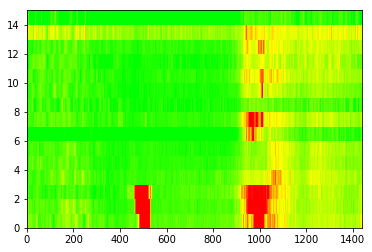

In [8]:
idx = 431  # test: [417,420,431]
print(data.loc[idx])

def vis_one_day_traffic_speed(speed):
    plt.pcolor(speed,cmap=my_cmap, vmin=20, vmax=70)
    
# vis_one_day_traffic_speed(db[257]['label'])
print(type(db[idx]['traffic']))
vis_one_day_traffic_speed(db[idx]['traffic'][:,:,0]) 

In [9]:
# data_test = data.loc[[417,420,431]]
# data_test = data_test.reset_index()

# data_train = data
# data_train = data_train.drop([417,420,431])
# data_train = data_train.reset_index()

## dataloader: load sample from database in batch

## batch added one more dimension to the left

## in case of multi-output and batch = 10, each sample:

## {'traffic':(10,15,1439,3),'weather':(10,15,1439,10),'history':(10,6,15,1439,3),'label':(10,15,1439)}

In [10]:
data_train = data[:-30]
data_train = data_train.reset_index()

data_val = data[-61:]
data_val = data_val.reset_index()

dataset = {}
dataset['train'] = LSTM_SpeedPrediction_database_output_multi_sensor(Traffic[:-30], Weather[:-30], data_train)
dataset['val'] = LSTM_SpeedPrediction_database_output_multi_sensor(Traffic[-61:], Weather[-61:], data_val)

dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=1000,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [11]:
# for sample in dataloaders['train']:
#     print('traffic: ',sample['traffic'].shape)
#     print('weather: ',sample['weather'].shape)
#     print('history: ',sample['history'].shape)
#     print('label: ',sample['label'].shape)

In [12]:
'''https://github.com/wkelongws/iemgrid'''
'''Weather: 0:tmpc 1:dwpc 2:smps 3:drct 4:vsby 5:roadtmpc 6:srad 7:snwd 8:pcpn '''

Traffic_max = []
Traffic_min = []
Weather_max = []
Weather_min = []

for i in range(Traffic.shape[-1]):
#     print(i,'max: ',np.max(Traffic[:,:,:,i]))
    Traffic_max.append(np.max(Traffic[:,:,:,i]))
#     print(i,'mean: ',np.mean(Traffic[:,:,:,i]))
#     print(i,'min: ',np.min(Traffic[:,:,:,i]))
    Traffic_min.append(np.min(Traffic[:,:,:,i]))
for i in range(Weather.shape[-1]):
#     print(i,'max: ',np.max(Weather[:,:,:,i]))
    Weather_max.append(np.max(Weather[:,:,:,i]))
#     print(i,'mean: ',np.mean(Weather[:,:,:,i]))
#     print(i,'min: ',np.min(Weather[:,:,:,i]))
    Weather_min.append(np.min(Weather[:,:,:,i]))
    
Min_Max = (Traffic_max,Traffic_min,Weather_max,Weather_min)

In [13]:
Min_Max[3]

[-25.0, -29.0, 0.0, 0.0, 0.0, -20.4, 0.0, 0.0, -36.0]

## LSTM Prediction Net
## Normalization on the fly. Normalize all numbers ~ (0,1)

In [14]:
class LSTM_Short_Term_Speed_Pred_Net(nn.Module):
    def __init__(self, filter_height = 5, output_single_sensor = False, \
                 hidden_dim = 16,use_gpu = True, use_volume_and_occup = False, \
                 use_weather = False, use_history = True, input_feature = 'cnn', Min_Max = Min_Max):
        super(LSTM_Short_Term_Speed_Pred_Net, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.out_dim = 15
        
        self.input_dim_today = self.out_dim
        self.input_dim_history = self.out_dim
        if input_feature == 'cnn':
            self.input_dim_today = self.out_dim - filter_height + 1
            self.input_dim_history = self.out_dim - filter_height + 1
#         else:
#             self.input_dim_today = self.out_dim
#             self.input_dim_history = self.out_dim
        
        if output_single_sensor:
            self.out_dim = out_dim = 1
        self.use_gpu = use_gpu
        
        self.use_volume_and_occup = use_volume_and_occup
        self.use_weather = use_weather
        self.use_history = use_history
#         assert input_feature in ['raw','linear','cnn'], 'wrong choice for input_feature'
        assert input_feature == 'cnn', 'currently only allow cnn as input feature extractor'
        self.input_feature = input_feature # ['raw','linear','CNN']
        
        '''for on-fly normalization'''
        self.Traffic_max = Min_Max[0]
        self.Traffic_min = Min_Max[1]
        self.Weather_max = Min_Max[2]
        self.Weather_min = Min_Max[3]
        
        if self.input_feature == 'cnn':
            self.CNN_for_history = nn.Conv2d(1, 1, (filter_height, 1), stride=(1, 1))
            self.CNN_feature_extract = nn.Conv2d(1, 1, (filter_height, 1), stride=(1, 1))
            if self.use_volume_and_occup:
                self.CNN_feature_extract = nn.Conv2d(1, 1, (filter_height, 3), stride=(1, 1))
            if self.use_weather:
                self.CNN_feature_extract = nn.Conv2d(1, 1, (filter_height, 12), stride=(1, 1))
        self.CNN_today_and_history_output_combine = nn.Conv2d(1, 1, (1, 2), stride=(1, 1))
        self.lstm_today = nn.LSTMCell(self.input_dim_today, self.hidden_dim)
        self.lstm_history = nn.LSTMCell(self.input_dim_history, self.hidden_dim)
        self.linear_out = nn.Linear(self.hidden_dim, self.out_dim)
        
    def init_hidden(self,input_sample):
        
        batch_size = input_sample['traffic'].shape[0]
        if self.use_gpu:
            return Variable(torch.zeros(batch_size, self.hidden_dim).cuda(), requires_grad=False)
        return Variable(torch.zeros(batch_size, self.hidden_dim), requires_grad=False)

    def LSTM_update(self,input_t,hidden_state_today,cell_state_today):
        input_t = input_t.squeeze(3).squeeze(1)
        hidden_state_today, cell_state_today = self.lstm_today(input_t, (hidden_state_today, cell_state_today))
        hidden_state_output = hidden_state_today
        return hidden_state_today, cell_state_today, hidden_state_output
 
    def LSTM_update_with_history(self,input_t,input_history,hidden_state_today,cell_state_today,hidden_state_history,cell_state_history):
        input_t = input_t.squeeze(3).squeeze(1)
        hidden_state_today, cell_state_today = self.lstm_today(input_t, (hidden_state_today, cell_state_today))
        if len(input_history)>0:
            for input_t_history in input_history:
                input_h = input_t_history.squeeze(3).squeeze(1)
                hidden_state_history, cell_state_history = self.lstm_history(input_h, (hidden_state_history, cell_state_history))

            h_combine = torch.stack([hidden_state_today,hidden_state_history],2)
            h_combine = h_combine.unsqueeze(1)
            hidden_state_output = self.CNN_today_and_history_output_combine(h_combine)
            hidden_state_output = hidden_state_output.squeeze(3).squeeze(1)
            return hidden_state_today, cell_state_today, hidden_state_output
        else:
            hidden_state_output = hidden_state_today
            return hidden_state_today, cell_state_today, hidden_state_output
        

    def forward(self, input_sample, future = 0, use_gpu = True):
        
        '''reconstruct data from sample'''
        traffic = input_sample['traffic']
        weather = input_sample['weather']
        history = input_sample['history']
        label = input_sample['label']
#         print('traffic: ',traffic.shape)
#         print('weather: ',weather.shape)
#         print('history: ',history.shape)
#         print('label: ',label.shape)
#         print()
#         print(np.sum(np.isnan(np.array(traffic))))
#         print(np.sum(np.isnan(np.array(weather))))
#         print(np.sum(np.isnan(np.array(history))))
        
        '''normalize'''
#         label = (label - self.Traffic_min[0])/(self.Traffic_max[0]-self.Traffic_min[0])
        for i in range(traffic.shape[-1]):
            traffic[:,:,:,i] = (traffic[:,:,:,i]-self.Traffic_min[i])/(self.Traffic_max[i]-self.Traffic_min[i])
            history[:,:,:,:,i] = (history[:,:,:,:,i]-self.Traffic_min[i])/(self.Traffic_max[i]-self.Traffic_min[i])
        for i in range(weather.shape[-1]):
            weather[:,:,:,i] = (weather[:,:,:,i]-self.Weather_min[i])/(self.Weather_max[i]-self.Weather_min[i])
        
#         print()
#         print(np.sum(np.isnan(np.array(traffic))))
#         print(np.sum(np.isnan(np.array(weather))))
#         print(np.sum(np.isnan(np.array(history))))
        '''re-arrange inputs'''
        input_today = traffic[:,:,:,0:1]
        
        if self.use_volume_and_occup:
            input_today = traffic
            
        if self.use_weather:
            input_today = torch.cat([traffic,weather],3)
            
        input_history = history[:,:,:,:,0:1]
            
        if use_gpu:
            input_today = Variable(input_today.cuda())
            input_history = Variable(input_history.cuda())
            label = Variable(label.cuda())
        else:
            input_today = Variable(input_today)
            input_history = Variable(input_history)
            label = Variable(label)
        
#         print()
#         print(np.sum(np.isnan(np.array(input_today.data))))
#         print(np.sum(np.isnan(np.array(input_history.data))))
        
        '''feedforward'''
        
        outputs = []
        hidden_state_today = self.init_hidden(input_sample)
        cell_state_today = self.init_hidden(input_sample)
        hidden_state_history = self.init_hidden(input_sample)
        cell_state_history = self.init_hidden(input_sample)
#         print(input_today.data.shape[2])
        for i in range(input_today.data.shape[2]):
            
            input_t = input_today[:,:,i:i+1,:]
            input_t = input_t.permute(0,2,1,3)
            
            input_t_history = []
#             print(input_history.shape[1])
            for k in range(input_history.shape[1]):
                if not np.isnan(np.array(input_history[0,k,0,0,0].data))[0]:
                    input_t_history.append(input_history[:,k,:,i+1:i+2,:].permute(0,2,1,3))
#             print(len(input_t_history))

            if self.input_feature == 'cnn':
                input_t = self.CNN_feature_extract(input_t)
                input_t_history = [self.CNN_for_history(x) for x in input_t_history]

            if self.use_history:
                hidden_state_today, cell_state_today, hidden_state_output = self.LSTM_update_with_history(input_t,input_t_history,hidden_state_today,cell_state_today,hidden_state_history,cell_state_history)
            else:
                hidden_state_today, cell_state_today, hidden_state_output = self.LSTM_update(input_t,hidden_state_today,cell_state_today)
            
            output = nn.functional.sigmoid(self.linear_out(hidden_state_output))
            output = output*(self.Traffic_max[0]-self.Traffic_min[0])+self.Traffic_min[0] 
            outputs += [output]
        outputs = torch.stack(outputs, 2)

        return outputs, label
        

In [15]:
use_gpu = torch.cuda.is_available()
# use_gpu = False

model = LSTM_Short_Term_Speed_Pred_Net(filter_height = 5, output_single_sensor = False, \
                 hidden_dim = 16,use_gpu = True, use_volume_and_occup = True, \
                 use_weather = True, use_history = True, input_feature = 'cnn')

if use_gpu:
    model = model.cuda()

In [ ]:
pred,label = model(sample)

In [ ]:
print(type(pred),pred.shape)
print(type(label),label.shape)

In [ ]:
print(np.sum(np.isnan(np.array(label.data))))
print(np.sum(np.isnan(np.array(pred.data))))

In [ ]:
np.max(np.array(pred.data))

In [ ]:
906570/(15*1439*3)

In [ ]:
cnt = 0
for sample in dataloaders['train']:
    cnt += 1
    if cnt == 1:
        s = sample
    b = sample['traffic']
    c = sample['weather']
    d = sample['history']
    e = sample['label']
    print(type(sample['traffic']))
    print('traffic: ',sample['traffic'].shape)
    print('weather: ',sample['weather'].shape)
    print('history: ',sample['history'].shape)
    print('label: ',sample['label'].shape)

In [ ]:
# def customized_loss(preds, targets):
    
#     preds = preds.view(preds.data.shape[0]*preds.data.shape[1],-1)
#     targets = targets.view(targets.data.shape[0]*targets.data.shape[1],-1)
    
#     pdist = nn.PairwiseDistance(p=2)
    
#     output = pdist(preds, targets)

#     loss = sum(output)/output.data.shape[0]
    
#     return loss

In [16]:
use_gpu = torch.cuda.is_available()
# use_gpu = False

model = LSTM_Short_Term_Speed_Pred_Net(filter_height = 5, output_single_sensor = False, \
                 hidden_dim = 16,use_gpu = True, use_volume_and_occup = True, \
                 use_weather = True, use_history = True, input_feature = 'cnn')

if use_gpu:
    model = model.cuda()

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
def train_LSTM_perVehiclePrediction_Net(model,dataloaders, criterion, optimizer, dataset_sizes, num_epochs=100):
    since = time.time()

#     timeSince(since)
#     model.load_state_dict(torch.load('Best_LSTM_Weights_1st'))
#     print()
#     print('keep training from previous "Best_LSTM_Weights_1st"')
#     print()

#     vanillaPlus_compromised_dict = torch.load('Best_LSTM_Weights_vanillaPlus')
#     vanillaPlus_compromised_dict['linear_out.weight'] = torch.randn(model.state_dict()['linear_out.weight'].shape).cuda()
#     vanillaPlus_compromised_dict['linear_out.bias'] = torch.randn(model.state_dict()['linear_out.bias'].shape).cuda()
#     model.load_state_dict(vanillaPlus_compromised_dict)
#     print()
#     print('weights in the output layer are initialized from normal distribution')
#     print('and other model weights are loaded from "Best_LSTM_Weights_vanillaPlus_compromised')
#     print('keep training from previous "Best_LSTM_Weights_vanillaPlus_compromised"')
#     print()

    best_model_wts = model.state_dict()
    best_loss = 100000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample in dataloaders[phase]:

                # zero the parameter gradients
                model.zero_grad()
                optimizer.zero_grad()
                
                # Also, we need to clear out the hidden state of the LSTM,
                # detaching it from its history on the last instance.
#                 model.hidden = model.init_hidden()
                
                # forward
                pred,label = model(sample)
                
                # loss function
#                 loss = customized_loss(pred,label)
                loss = criterion(pred,label)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f} total elapsed time: {}'.format(phase, epoch_loss, timeSince(since)))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()
#                 torch.save(best_model_wts, 'Best_LSTM_Weights')
                print('Weights saved to "Best_LSTM_Weights"')

        print()

    print('Training complete in {}'.format(timeSince(since)))
    print('Best val loss: {:4f}'.format(best_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model, 'Model_with_Best_LSTM_Weights')
    print('Model saved to "Model_with_Best_LSTM_Weights"')
    return model

In [19]:
model_ft = train_LSTM_perVehiclePrediction_Net(model,dataloaders, criterion, optimizer, dataset_sizes, num_epochs=1000)